In [1]:
import numpy as np
import torch
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from torch.autograd import Variable
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from time import time
import sklearn.preprocessing
import numpy as np
import robust_onlinehd
from GenAttack import GenAttack

In [2]:
scaler = sklearn.preprocessing.Normalizer()

In [3]:
torch.manual_seed(54)

In [4]:

# loads simple mnist dataset
def load():  
    (x, y), (x_test, y_test) = fashion_mnist.load_data()

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()   
    y = torch.from_numpy(y).long().squeeze()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long().squeeze()
    
    if len(x.shape) == 3:
        x = x.unsqueeze(3)
        x_test = x_test.unsqueeze(3)

    return x, x_test, y, y_test


print('Loading...')
x, x_test, y, y_test = load()

Loading...


<ipython-input-4-84a179f8522e>:6: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  x = torch.from_numpy(x).float()


In [5]:
#criterias = [(0, 100, 0), (100, 150, 125), (150, 200, 175), (200, 256, 255)]
criterias = [(0, 50, 0), (50, 100, 75), (100, 125, 124), (125, 150, 149), (150, 175, 174), (175, 200, 199), (200, 225, 224), (225, 256, 255)]
#criterias = []
kernel_size = 3
#kernel_size = 1
classes = y.unique().size(0)
features = x.size(1) * x.size(2)
model = robust_onlinehd.OnlineHD(criterias, kernel_size, scaler, classes, features, dim = 10000)


if torch.cuda.is_available():
    #x = x.cuda()
    #y = y.cuda()
    #x_test = x_test.cuda()
    #y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()

model = model.fit(x, y, bootstrap=.3, lr=0.095, epochs=300, batch_size=8196)
t = time() - t

print('Validating...')
yhat = model(x).cpu()
yhat_test = model(x_test).cpu()
acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{t = :6f}')


Using GPU!
Training...
Validating...
acc = 0.970067
acc_test = 0.861800
t = 30.045258


In [6]:
preds = model(x_test).cpu().numpy()
#preds = model(x).cpu().numpy()

In [7]:
targets = torch.randint(0, 10, preds.shape)
for i in tqdm(range(len(preds))):
    while targets[i] == preds[i]:
        targets[i] = torch.randint(0,10, (1,)).item()

100%|██████████| 10000/10000 [00:00<00:00, 52678.03it/s]


In [8]:
unif = torch.ones(targets.shape[0])
while True:
    indices = unif.multinomial(100)
    for idx in indices:
        if targets[idx] == y_test[idx]:
            break
    if idx == indices[-1] and targets[idx] != y_test[idx]:
        break
    else:
        indices = unif.multinomial(100)

In [9]:
attacker = GenAttack(model, classes, 28 * 28, scaler, 0.6, 'cuda')
N = 8                          # size of population to evolve
G = 5000                        # number of generations to evolve through
p = torch.FloatTensor([0.9])   # the parameter for Bernoulli distribution used in mutation
alpha = torch.FloatTensor([1.0]) # the parameter controlling mutation amount (step-size in the original paper)
delta = torch.FloatTensor([0.9]) # the parametr controlling mutation amount (norm threshold in the original paper)

In [10]:
pops = []
results = []

In [11]:
t = time()
for i in tqdm(indices):
    temp = attacker.attack(x_test[i], targets[i], delta, alpha, p, N, G)
    pops.append(temp[0].numpy())
    results.append(temp[1])
t = time() - t

print(f'{t = :6f}')

  1%|          | 1/100 [00:57<1:34:27, 57.25s/it]

All 5000 generations failed.


  2%|▏         | 2/100 [01:54<1:33:57, 57.53s/it]

All 5000 generations failed.


  3%|▎         | 3/100 [02:52<1:33:08, 57.61s/it]

All 5000 generations failed.


  4%|▍         | 4/100 [03:50<1:32:02, 57.53s/it]

All 5000 generations failed.


  5%|▌         | 5/100 [04:47<1:31:18, 57.67s/it]

All 5000 generations failed.


  6%|▌         | 6/100 [05:45<1:30:08, 57.54s/it]

All 5000 generations failed.


  7%|▋         | 7/100 [06:42<1:29:07, 57.50s/it]

All 5000 generations failed.


  8%|▊         | 8/100 [07:39<1:28:03, 57.43s/it]

All 5000 generations failed.


  9%|▉         | 9/100 [08:40<1:28:38, 58.45s/it]

All 5000 generations failed.


 10%|█         | 10/100 [08:46<1:03:14, 42.16s/it]

Attack Success at generation 484


 11%|█         | 11/100 [09:43<1:09:22, 46.77s/it]

All 5000 generations failed.


 12%|█▏        | 12/100 [10:40<1:13:12, 49.92s/it]

All 5000 generations failed.


 13%|█▎        | 13/100 [11:38<1:15:51, 52.32s/it]

All 5000 generations failed.


 14%|█▍        | 14/100 [12:35<1:17:05, 53.78s/it]

All 5000 generations failed.


 15%|█▌        | 15/100 [13:33<1:17:47, 54.92s/it]

All 5000 generations failed.


 16%|█▌        | 16/100 [14:32<1:18:31, 56.09s/it]

All 5000 generations failed.


 17%|█▋        | 17/100 [15:31<1:18:55, 57.05s/it]

All 5000 generations failed.


 18%|█▊        | 18/100 [16:29<1:18:31, 57.45s/it]

All 5000 generations failed.


 19%|█▉        | 19/100 [17:28<1:18:02, 57.80s/it]

All 5000 generations failed.


 20%|██        | 20/100 [18:27<1:17:26, 58.08s/it]

All 5000 generations failed.


 21%|██        | 21/100 [19:27<1:17:30, 58.87s/it]

All 5000 generations failed.


 22%|██▏       | 22/100 [20:28<1:17:20, 59.49s/it]

All 5000 generations failed.


 23%|██▎       | 23/100 [21:26<1:15:46, 59.04s/it]

All 5000 generations failed.


 24%|██▍       | 24/100 [22:24<1:14:11, 58.57s/it]

All 5000 generations failed.


 25%|██▌       | 25/100 [23:21<1:12:53, 58.32s/it]

All 5000 generations failed.


 26%|██▌       | 26/100 [24:19<1:11:40, 58.12s/it]

All 5000 generations failed.


 27%|██▋       | 27/100 [25:16<1:10:24, 57.87s/it]

All 5000 generations failed.


 28%|██▊       | 28/100 [26:14<1:09:31, 57.94s/it]

All 5000 generations failed.


 29%|██▉       | 29/100 [27:12<1:08:27, 57.85s/it]

All 5000 generations failed.


 30%|███       | 30/100 [28:10<1:07:27, 57.82s/it]

All 5000 generations failed.


 31%|███       | 31/100 [29:12<1:07:57, 59.10s/it]

All 5000 generations failed.
All candidates died at generation 0
Target =  tensor(0, device='cuda:0')


 33%|███▎      | 33/100 [30:10<50:35, 45.30s/it]  

All 5000 generations failed.


 34%|███▍      | 34/100 [31:09<53:29, 48.63s/it]

All 5000 generations failed.


 35%|███▌      | 35/100 [32:07<55:13, 50.97s/it]

All 5000 generations failed.


 36%|███▌      | 36/100 [33:04<56:17, 52.77s/it]

All 5000 generations failed.


 37%|███▋      | 37/100 [34:02<56:56, 54.23s/it]

All 5000 generations failed.


 38%|███▊      | 38/100 [35:00<56:58, 55.14s/it]

All 5000 generations failed.


 39%|███▉      | 39/100 [35:57<56:45, 55.83s/it]

All 5000 generations failed.


 40%|████      | 40/100 [36:55<56:33, 56.56s/it]

All 5000 generations failed.


 41%|████      | 41/100 [37:54<56:11, 57.14s/it]

All 5000 generations failed.


 42%|████▏     | 42/100 [38:51<55:13, 57.13s/it]

All 5000 generations failed.


 43%|████▎     | 43/100 [39:48<54:16, 57.13s/it]

All 5000 generations failed.


 44%|████▍     | 44/100 [40:46<53:22, 57.19s/it]

All 5000 generations failed.


 45%|████▌     | 45/100 [41:44<52:52, 57.69s/it]

All 5000 generations failed.


 46%|████▌     | 46/100 [42:44<52:22, 58.19s/it]

All 5000 generations failed.


 47%|████▋     | 47/100 [42:45<36:17, 41.08s/it]

Attack Success at generation 88


 48%|████▊     | 48/100 [43:45<40:32, 46.77s/it]

All 5000 generations failed.


 49%|████▉     | 49/100 [43:46<28:03, 33.01s/it]

Attack Success at generation 74


 50%|█████     | 50/100 [44:43<33:35, 40.31s/it]

All 5000 generations failed.


 51%|█████     | 51/100 [45:41<37:07, 45.47s/it]

All 5000 generations failed.


 52%|█████▏    | 52/100 [46:40<39:36, 49.52s/it]

All 5000 generations failed.


 53%|█████▎    | 53/100 [47:37<40:36, 51.84s/it]

All 5000 generations failed.


 54%|█████▍    | 54/100 [48:36<41:24, 54.00s/it]

All 5000 generations failed.


 55%|█████▌    | 55/100 [49:33<41:10, 54.89s/it]

All 5000 generations failed.


 56%|█████▌    | 56/100 [50:31<40:53, 55.75s/it]

All 5000 generations failed.


 57%|█████▋    | 57/100 [51:28<40:17, 56.23s/it]

All 5000 generations failed.


 58%|█████▊    | 58/100 [52:25<39:36, 56.59s/it]

All 5000 generations failed.


 59%|█████▉    | 59/100 [53:23<38:50, 56.84s/it]

All 5000 generations failed.


 60%|██████    | 60/100 [54:20<38:00, 57.02s/it]

All 5000 generations failed.


 61%|██████    | 61/100 [55:18<37:10, 57.19s/it]

All 5000 generations failed.


 62%|██████▏   | 62/100 [55:36<28:50, 45.54s/it]

All candidates died at generation 1603
Target =  tensor(0, device='cuda:0')


 63%|██████▎   | 63/100 [56:33<30:14, 49.05s/it]

All 5000 generations failed.


 64%|██████▍   | 64/100 [57:32<31:02, 51.75s/it]

All 5000 generations failed.


 65%|██████▌   | 65/100 [58:29<31:09, 53.42s/it]

All 5000 generations failed.


 66%|██████▌   | 66/100 [59:27<31:00, 54.72s/it]

All 5000 generations failed.


 67%|██████▋   | 67/100 [1:00:26<30:50, 56.07s/it]

All 5000 generations failed.


 68%|██████▊   | 68/100 [1:01:25<30:24, 57.01s/it]

All 5000 generations failed.


 69%|██████▉   | 69/100 [1:02:23<29:34, 57.25s/it]

All 5000 generations failed.


 70%|███████   | 70/100 [1:03:26<29:32, 59.07s/it]

All 5000 generations failed.


 71%|███████   | 71/100 [1:04:24<28:20, 58.65s/it]

All 5000 generations failed.


 72%|███████▏  | 72/100 [1:05:21<27:11, 58.28s/it]

All 5000 generations failed.


 73%|███████▎  | 73/100 [1:06:18<26:04, 57.96s/it]

All 5000 generations failed.


 74%|███████▍  | 74/100 [1:07:16<25:02, 57.79s/it]

All 5000 generations failed.


 75%|███████▌  | 75/100 [1:08:16<24:20, 58.43s/it]

All 5000 generations failed.


 76%|███████▌  | 76/100 [1:09:16<23:38, 59.09s/it]

All 5000 generations failed.


 77%|███████▋  | 77/100 [1:10:14<22:29, 58.69s/it]

All 5000 generations failed.


 78%|███████▊  | 78/100 [1:11:12<21:26, 58.46s/it]

All 5000 generations failed.


 79%|███████▉  | 79/100 [1:12:13<20:44, 59.27s/it]

All 5000 generations failed.


 80%|████████  | 80/100 [1:13:13<19:50, 59.52s/it]

All 5000 generations failed.


 81%|████████  | 81/100 [1:14:11<18:39, 58.91s/it]

All 5000 generations failed.


 82%|████████▏ | 82/100 [1:15:08<17:32, 58.48s/it]

All 5000 generations failed.


 83%|████████▎ | 83/100 [1:16:06<16:31, 58.35s/it]

All 5000 generations failed.


 84%|████████▍ | 84/100 [1:17:04<15:29, 58.09s/it]

All 5000 generations failed.


 85%|████████▌ | 85/100 [1:18:02<14:29, 57.98s/it]

All 5000 generations failed.


 86%|████████▌ | 86/100 [1:19:01<13:38, 58.46s/it]

All 5000 generations failed.


 87%|████████▋ | 87/100 [1:20:00<12:41, 58.56s/it]

All 5000 generations failed.


 88%|████████▊ | 88/100 [1:20:57<11:39, 58.25s/it]

All 5000 generations failed.


 89%|████████▉ | 89/100 [1:21:55<10:39, 58.10s/it]

All 5000 generations failed.


 90%|█████████ | 90/100 [1:22:53<09:40, 58.04s/it]

All 5000 generations failed.


 91%|█████████ | 91/100 [1:23:51<08:40, 57.88s/it]

All 5000 generations failed.


 92%|█████████▏| 92/100 [1:24:50<07:46, 58.33s/it]

All 5000 generations failed.


 93%|█████████▎| 93/100 [1:25:51<06:54, 59.25s/it]

All 5000 generations failed.


 94%|█████████▍| 94/100 [1:25:53<04:11, 41.95s/it]

Attack Success at generation 134


 95%|█████████▌| 95/100 [1:26:50<03:52, 46.58s/it]

All 5000 generations failed.


 96%|█████████▌| 96/100 [1:27:49<03:20, 50.13s/it]

All 5000 generations failed.


 97%|█████████▋| 97/100 [1:28:49<02:39, 53.24s/it]

All 5000 generations failed.


 98%|█████████▊| 98/100 [1:29:47<01:48, 54.46s/it]

All 5000 generations failed.


 99%|█████████▉| 99/100 [1:30:44<00:55, 55.28s/it]

All 5000 generations failed.


100%|██████████| 100/100 [1:31:41<00:00, 55.02s/it]

All 5000 generations failed.
t = 5501.917376


In [12]:
pops = np.array(pops)

In [13]:
sample_preds = preds[indices]

In [14]:
new_preds = []
for i in range(100):
    new_preds.append(model(torch.tensor(pops[i])).cpu().numpy())

In [15]:
success = 0
success_idx = []
for i in range(100):
    if targets[indices[i]].item() in new_preds[i]:
        success_idx.append((indices[i].item(), (i, np.where(new_preds[i] == targets[indices[i]].item())[0][0])))
        success += 1
print(success)

4


In [16]:
cache = {
    'indices' : indices,
    'sample_preds' : sample_preds,
    'pops' : np.array(pops),
    'hyper_parameter' : [N, G, p, alpha, delta],
    'success_idx' : success_idx,
    'model' : model, 
    'scaler' : model.scaler,
    'targets' : targets,
    'results' : results
}

In [17]:
torch.save(cache, 'robust_onlinehd_fashion_mnist.pt')

In [18]:
model(torch.tensor(pops[0]))

tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [19]:
labels = {
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}

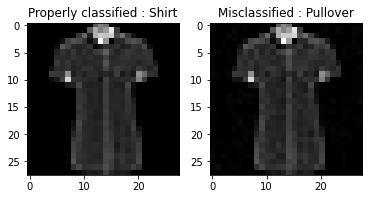

In [20]:
origin_idx, (new_idx, new_idx_idx) = success_idx[torch.randint(0, len(success_idx), (1,)).item()]

f, axes = plt.subplots(1, 2)
axes[0].imshow(x_test[origin_idx], cmap=plt.gray())
_ = axes[0].set_title('Properly classified : %s' % labels[sample_preds[new_idx].item()])
axes[1].imshow(pops[new_idx][new_idx_idx].astype(np.int32))
_ = axes[1].set_title('Misclassified : %s' % labels[new_preds[new_idx][new_idx_idx]])